In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn,autograd
from torchvision import transforms
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch.nn.functional as F

In [3]:
os.listdir('../input/flickr-image-dataset/flickr30k_images')

['flickr30k_images', 'results.csv']

In [4]:
metadata = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/results.csv',delimiter='|',engine='python')
metadata = metadata.dropna()
is_NaN = metadata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = metadata[row_has_NaN]
print(rows_with_NaN)
metadata.head()

Empty DataFrame
Columns: [image_name,  comment_number,  comment]
Index: []


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
def load_image(name):
    img = image.load_img(name,target_size=(128,128,3))
    img = image.img_to_array(img)
#     img = img/255
    
    #plt.imshow(img)
#     img = np.reshape(img,(224*224*3))
    return img.T

In [6]:
dict_ = {}
for index,row in metadata.iterrows():
    if row['image_name'] in dict_:
        dict_[row['image_name']].append('<SOS>'+row[' comment']+'<EOS>')
    else:
        dict_[row['image_name']]=['<SOS>'+row[' comment']+'<EOS>']
print(len(dict_))

31783


In [7]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    # TODO: Implement
    return t, tokenizer

In [8]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding


In [9]:
def preprocess(sentences):
    text_tokenized, text_tokenizer = tokenize(sentences)
    text_pad = pad(text_tokenized)
    return text_pad, text_tokenizer

In [10]:
loc = '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
image_arr = []
sentence_arr = []
for ind in range(20000):
    if ind % 2 != 0:
        continue
    image_location = (metadata.iloc[ind,:]['image_name'])
    sentence = dict_[image_location]
    
    
    image_arr.append(load_image(loc+str(image_location)) )
    sentence_arr.extend(sentence) #append all 5 captions for that image
    
        
Images =  np.array(image_arr)

In [11]:
Sentence , token_Sentence = preprocess(sentence_arr)

In [12]:
Images =  np.array(image_arr)

In [13]:
Sentence.shape,Images.shape

((49998, 80), (10000, 3, 128, 128))

## Custom architecture

In [14]:
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')


In [15]:
# device = torch.device("cuda" if torch.cuda.device else "cpu")
# device='cpu'
vocab_size=len(token_Sentence.word_index)+1
embedding_size = 512
batch_size=1
max_len_t = len(Sentence[0])
patch_size=16
img_size=128
num_patches = (img_size * img_size) // patch_size**2 

In [16]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 512.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=512):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
#         self.flatten = nn.Flatten()
        
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)# only flatten the feature map dimensions into a single vector

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
#         print(x_flattened.shape)
#         print(x_flattened.permute(2,0,1).shape)
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(2,0,1) #.permute(0,2,1)

In [17]:
class encoder(nn.Module):
    def __init__(self, img_size=img_size,embedding_dim=512,patch_size=16,num_channels=3):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim).to(cuda0)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=512,
                                                     nhead=4,
                                                     dim_feedforward=2048,
                                                     activation="gelu",
#                                                      batch_first=True,
#                                                      norm_first=True,
                                                     device=cuda0), # Create a single Transformer Encoder Layer
                                                     num_layers=2).to(cuda0)
        #creating positional embedding

        num_patches = (img_size * img_size) // patch_size**2 
        self.positional_embedding = nn.Parameter(torch.randn(num_patches,batch_size,embedding_dim)).to(cuda0)
        
        self.embedding_dropout = nn.Dropout(p=0.1).to(cuda0)
    def forward(self,images):
        
        batches = images.shape[0]
        x = self.patch_embedding(images)
#         print('patch embed',x.shape)
#         x = x[np.newaxis,0:].T
#         print('position embed',self.positional_embedding.shape)
        x = self.positional_embedding + x
        x.requires_grad_()
        trans_encoder = self.transformer_encoder(x)
        return trans_encoder#(1,0,2) 2 is the last index , 0 is the batchsize

In [18]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder()
        self.trg_word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=embedding_size,
                                                     nhead=4,
#                                                      batch_first=True,
                                                     activation='gelu',
#                                                      norm_first=True,
                                                     device=cuda0), 
                                                     num_layers=2).to(cuda0)
        self.out = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(0.2).to(cuda0)
    
    def mask(self,sz):
        
        mask = (torch.triu(torch.ones(sz[0], sz[0])) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')). \
        masked_fill(mask == 1, float(0.0))
        return mask
  
        
    def forward(self,img,trg):
#         print(trg.shape)
#         print(type(trg))
#         print(self.trg_word_embedding)
        trg=trg.type(torch.int64)
        trg_seq_length,N = trg.shape
#         print('in gene',trg_seq_length)
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length,N)
            
        ).to(cuda0)
#         print(trg_positions)

        embed_trg = self.dropout(
                self.trg_word_embedding(trg) +
                 self.trg_position_embedding(trg_positions)
            )
        in_features = self.encoder(img)
#         print('the shape of mat from encoder is ',in_features.shape,
#               '\n embeded trg',embed_trg.shape)
        in_features.requires_grad_()
        trg_mask = self.mask(trg.shape).to(cuda0)
        logits = self.transformer_decoder(embed_trg,in_features,tgt_mask=trg_mask) #in_features is from the encoder
        
        logits = self.out(logits)
#         print(logits.shape)
        return logits

In [19]:
i=1
s = torch.from_numpy(Sentence[(i-1)*batch_size : (i-1)*1 + batch_size]).type(torch.long).T.shape
# f=(Images[np.newaxis,0:]).shape
f = torch.from_numpy(Images[0:1]).to(torch.long).shape

In [20]:
s,f

(torch.Size([80, 1]), torch.Size([1, 3, 128, 128]))

In [21]:
summary(model=generator(),input_size=(f,s))

Layer (type:depth-idx)                             Output Shape              Param #
generator                                          [80, 1, 7819]             --
├─Embedding: 1-1                                   [80, 1, 512]              4,003,328
├─Embedding: 1-2                                   [80, 1, 512]              40,960
├─Dropout: 1-3                                     [80, 1, 512]              --
├─encoder: 1-4                                     [64, 1, 512]              --
│    └─PatchEmbedding: 2-1                         [64, 1, 512]              --
│    │    └─Conv2d: 3-1                            [1, 512, 8, 8]            393,728
│    │    └─Flatten: 3-2                           [1, 512, 64]              --
│    └─TransformerEncoder: 2-2                     [64, 1, 512]              --
│    │    └─ModuleList: 3-3                        --                        6,304,768
├─TransformerDecoder: 1-5                          [80, 1, 512]              --
│    └─Modul

In [22]:
class discriminator(nn.Module):
    def __init__(self,img_size=img_size,embedding_dim=512,patch_size=16,num_channels=3):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim).to(cuda1)
        self.transformer_decoder = nn.TransformerDecoder(
                decoder_layer=nn.TransformerDecoderLayer(d_model=embedding_size,
                                                         nhead=4,
                                                         activation='gelu',
                                                         device=cuda1), 
                                                         num_layers=2).to(cuda1)
        self.trg_word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)
        
        self.out = nn.Sequential(
            nn.Flatten(start_dim=0,end_dim=-1),
            nn.Linear(40960,1),
            nn.Sigmoid())
       
        self.dropout = nn.Dropout(0.2).to(cuda1)
        
    def forward(self,img,trg):
        
        trg=trg.type(torch.int64)
#         print(trg.shape)
        trg_seq_length,N = trg.shape
#         print('in dis',trg_seq_length)
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length,N)
            
        ).to(cuda1)
#         print(trg_positions)
        

        embed_trg = self.dropout(
                self.trg_word_embedding(trg) +
                 self.trg_position_embedding(trg_positions)
            )
#         print(embed_trg.shape)
        x = self.patch_embedding(img)
        
        prob = self.out(self.transformer_decoder(embed_trg,x))
        return prob # 0/1 for fake and real

In [23]:
summary(model=discriminator(),input_size=(f,s))

Layer (type:depth-idx)                        Output Shape              Param #
discriminator                                 [1]                       --
├─Embedding: 1-1                              [80, 1, 512]              4,003,328
├─Embedding: 1-2                              [80, 1, 512]              40,960
├─Dropout: 1-3                                [80, 1, 512]              --
├─PatchEmbedding: 1-4                         [64, 1, 512]              --
│    └─Conv2d: 2-1                            [1, 512, 8, 8]            393,728
│    └─Flatten: 2-2                           [1, 512, 64]              --
├─TransformerDecoder: 1-5                     [80, 1, 512]              --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerDecoderLayer: 3-1      [80, 1, 512]              4,204,032
│    │    └─TransformerDecoderLayer: 3-2      [80, 1, 512]              4,204,032
├─Sequential: 1-6                             [1]                

## train the gan model along with the encoder

In [24]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

In [25]:
def create_batch(src, tar , batchsize , i):
    

    src=  src[(i-1)*batchsize : (i-1)*batchsize + batchsize]
    tar =tar[(1-1)*batchsize : (1-1)*batchsize + batchsize]
#     print(tar.shape)
    return torch.tensor(src).float(),torch.tensor(tar).T.long()

In [26]:
c = generator().to(cuda0)

optimizer = torch.optim.SGD(c.parameters(),lr=0.01, momentum=0.9,nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True,
)
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()

In [27]:
d = discriminator().to(cuda1)
d_optimizer = torch.optim.Adam(d.parameters(),lr=0.1)
d_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
d_optimizer, factor=0.1, patience=10, verbose=True)
d_criterioin = nn.BCELoss().to(cuda1)   #therewas no .to


In [28]:
d_device = next(d.parameters()).device
c_device = next(c.parameters()).device

## Gradient penality

In [29]:
# def gradient_penalty(D, xr, xf):
    
    
#     # [b, 1]
#     t = torch.rand(batch_size, 1).to(device)
#     # [b, 1] => [b, 2]  broadcasting so t is the same for x1 and x2
#     t = t.expand_as(xr)
#     # interpolation
#     mid = t * xr + (1 - t) * xf
#     # set it to require grad info
#     mid.requires_grad_()    
#     pred = D(mid,t)
#     grads = autograd.grad(outputs=pred, inputs=mid,
#                           grad_outputs=torch.ones_like(pred),
#                           create_graph=True, retain_graph=True, only_inputs=True)[0] 
#     gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()
#     return gp

In [30]:
real = torch.ones(1).to(d_device)
fake = torch.zeros(1).to(d_device)
real

tensor([1.], device='cuda:1')

In [31]:
!pip install GPUtil
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
def free_gpu_cache():                
    torch.cuda.empty_cache()
    gc.collect()

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=6641a85fc3bba558311561f44b8ee264ce144c5ff15c2b0f0a5168a79d6094d3
  Stored in directory: /root/.cache/pip/wheels/b1/e7/99/2b32600270cf23194c9860f029d3d5db075f250bc39028c045
Successfully built GPUtil


In [32]:
import time

import random
def train(i,j):
    
    c.train()
    start = i
    end = j
    start_time = time.time()
    
    for rep in range(5): 
        total_loss = 0
        for i in range(start,end):
            '''sentence is already preprocessed
            the image is normal image and encoder does the image embedding 
            then the generator takes the image embedding from the encoder and predicts the caption
            then discriminator's job is to correct the generator to learn the caption from the image.
            The sentence has to similar to any-one of the 5 sentences in the dataset.
            This caption need not be same but it is expected to be 95% similar to atleast one of them
            '''

            
            s = Sentence[(i-1)*5:((i-1)*5)+5]

            random.shuffle(s)

            src,tar = create_batch(Images,s, batch_size , i)

            src=src.detach().clone().to(d_device)
            tar=tar.detach().clone().to(d_device)
            src1=src.detach().clone().to(c_device)
            tar1=tar.detach().clone().to(c_device)

            for _ in range(3): # passing the same text 10 times
                d.train()
                pred_r=d(src,tar)

                lossr = -d_criterioin(pred_r,real).mean()

                # 1.2 train on fake data
                
                xf = c(src1,tar1)  # gradient would not be passed down
                val, ind = torch.max(xf.view(-1, xf.shape[2]), 1)
                ind = torch.tensor(ind).reshape(80,1).to(d_device)

                predf = d(src,ind) 
                
                # min predf
                lossf =d_criterioin(predf,fake).mean()
                # 1.3 gradient penalty
#                 gp = gradient_penalty(d, tar, xf.detach())            # aggregate all
                loss_D = lossr + lossf           # optimize

                d_optimizer.zero_grad()
                loss_D.backward()
                torch.nn.utils.clip_grad_norm_(d.parameters(), 0.5)
                d_optimizer.step()
                free_gpu_cache()
            



            # 2. train caption model

            xf = c(src1,tar1)

            loss_G=criterion(xf.view(-1, xf.shape[2]), tar1.reshape(-1))
    #         print('after loss',xf.shape,'vs',tar.reshape(-1).shape)
            optimizer.zero_grad()
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(c.parameters(), 0.5)
            optimizer.step()
        #detach the inputs
            src.detach()
            tar.detach()
            src1.detach()
            tar1.detach()
            total_loss+=loss_G.item()
 
            if i % 200==0:

                elapsed = time.time() - start_time
                print('rep = ',rep+1,'  loss = ',loss_G,
                      '    time elapesed ',round(elapsed  / 200,2))

                start_time = time.time()
        print('*'*50)
    return total_loss
    
        

In [33]:
def save_model(epoch):
    i ='c'+str(epoch)+'.h5'
    torch.save(c,i) #that particular epoch model
    print('model saved')

In [34]:
import math
start,end = 1,1999
for epoch in range(1, 6):
    epoch_start_time = time.time()
    loss = train(start,end)
    start+=1999
    end+=1999
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | Training loss {:5.2f} | '
          .format(epoch, (time.time() - epoch_start_time),loss))
    save_model(epoch)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


rep =  1   loss =  tensor(4.7254, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.79
rep =  1   loss =  tensor(2.7933, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.78
rep =  1   loss =  tensor(4.2265, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.79
rep =  1   loss =  tensor(2.5313, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.77
rep =  1   loss =  tensor(2.7015, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.77
rep =  1   loss =  tensor(3.5247, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.76
rep =  1   loss =  tensor(2.3832, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.76
rep =  1   loss =  tensor(2.5687, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.76
rep =  1   loss =  tensor(2.0733, device='cuda:0', grad_fn=<NllLossBackward0>)     time elapesed  0.76
**************************************************
rep =  2   loss =  ten

## Evaluation 

### For diversity lets use n-gram diversity and for similarity lets use BLEU score and CIDEr

In [35]:
torch.save(c,'c.h5')

In [36]:
# loading the model


# c = generator()
# model_state_dict = torch.load(PATH) # loading the dictionary object
# c.load_state_dict(model_state_dict) # load_state_dict() function takes a dictionary object, NOT a path to a saved object
# c.eval() # since we need to use the model for inference


In [37]:
def display_image(name):
    img = image.load_img(name,target_size=(512,512,3))
    img = image.img_to_array(img)
    img = img/255
    plt.imshow(img)

In [38]:
from nltk.translate.bleu_score import sentence_bleu
def evaluate(index):
    ref = ' '.join(metadata[' comment'][index].split())
    
    image_location, sent = metadata.iloc[index,0],metadata.iloc[index,2]
    other = dict_[image_location]
    image_arr = []
    img = load_image(loc+str(image_location))
    image_arr.append(img)
    img_arr = np.array(image_arr)
    sentence = []
    sentence.append(sent)
    sentence[0] = '<SOS> '+sentence[0]+'<EOS>'
    sentence = pad(token_Sentence.texts_to_sequences(sentence) , length = max_len_t)
    src , tar = create_batch(img_arr,sentence, 1,1)
    src = src.to(c_device)
    tar = tar.to(c_device)
    c.eval()
    output =  c(src,tar)
    src.detach()
    tar.detach()
    loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    sentence_formed = ''
    val, ind = torch.max(output.view(-1, output.shape[2]), 1)
    for word in ind:
        #print('--->'+sentence_formed+'    '+str(word.item()))
        if word.item() == 3: # EOS
                break
        for key, value in token_Sentence.word_index.items():
            #print(value == word.item()) 
            if value == word.item() and value != 2: # sos
                sentence_formed = sentence_formed + key +' '
                break
    display_image('../input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+str(image_location))
#     print('loss = ',loss)
#     print(output)
    
    print('Individual 1-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(ref.split(), sentence_formed.split(), weights=(0, 0, 0, 1)))
    score = sentence_bleu(ref.split(), sentence_formed.split(),weights=(0.25, 0.5, 0.15, 0.10))
    print('Orginal ->',ref)
    print('Bleu Score is {}'.format(score))
    for s,i in zip(other,range(5)):
        print(i,s[5,-5])
    print('Sentence Formed', sentence_formed)
    return

Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Orginal -> Two young , White males are outside near many bushes .
Bleu Score is 0


TypeError: string indices must be integers

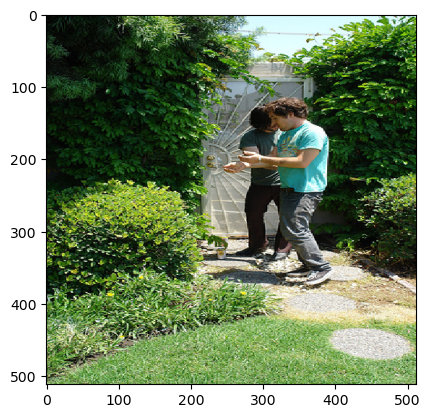

In [39]:
evaluate(1)

In [ ]:
evaluate(11)

In [ ]:
evaluate(6000)

In [ ]:
evaluate(26000)

In [ ]:
evaluate(23)

In [ ]:
evaluate(150)

In [ ]:
evaluate(105)